In [302]:
class Value:
    def __init__(self, value, parents=[], parent_op=None):
        self.value = value
        self.parents = parents  # e.g. for y = x * x, y has one parent x, rather than two parents [x, x] (so we don't accumulate gradients twice)
        self.parent_op = parent_op
        self.grad = 0
        self.grad_adj = dict()  # This stores all ∂self/∂parent partial dervative values, for all parents

    def __repr__(self):
        return str(self.value)
    
    # Called by: self + other
    def __add__(self, other):
        if not isinstance(other, Value): other = Value(other)
        output = Value(self.value + other.value, [self, other], '+')
        
        output.grad_adj[self] = 1
        output.grad_adj[other] = 1
        
        return output
    
    # Called by: other + self
    def __radd__(self, other):
        return self.__add__(other)
    
    # Called by: self - other
    def __sub__(self, other):
        if not isinstance(other, Value): other = Value(other)
        output = Value(self.value - other.value, [self, other], '-')
            
        output.grad_adj[self] = 1
        output.grad_adj[other] = -1 
        
        return output
    
    # Called by: other - self
    def __rsub__(self, other):  # other - self calls this
        if not isinstance(other, Value): other = Value(other)
        output = Value(other.value - self.value, [self, other], '-')
        
        output.grad_adj[self] = -1
        output.grad_adj[other] = 1
            
        return output
    
    # Called by: self * other
    def __mul__(self, other):
        if not isinstance(other, Value): other = Value(other)
        output = Value(self.value * other.value, [self, other], '*')
        
        output.grad_adj[self] = other.value
        output.grad_adj[other] = self.value
            
        return output
    
    # Called by: other * self
    def __rmul__(self, other):
        return self.__mul__(other)

    # Called by: self / other
    def __truediv__(self, other):
        if not isinstance(other, Value): other = Value(other)
        output = Value(self.value / other.value, [self, other], '/')
        
        output.grad_adj[self] = 1 / other.value
        output.grad_adj[other] = -self.value / other.value**2
        
        return output
    
    # Called by: other / self
    def __rtruediv__(self, other):
        if not isinstance(other, Value): other = Value(other)
        output = Value(other.value / self.value, [self, other], '/')
        
        output.grad_adj[self] = -other.value / self.value**2
        output.grad_adj[other] = 1 / self.value
            
        return output
  
    # Called by: self**other
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'minigrad does not support a Value in the exponent'
        output = Value(self.value ** other, [self], f'^{other}')
        
        output.grad_adj[self] = other * self.value**(other - 1)

        return output
    
    # Called by: -self
    def __neg__(self):
        return self.__mul__(-1)
    
    # Called by: self.relu()
    def relu(self):
        output = Value(max(self.value, 0), [self], 'relu')
        
        output.grad_adj[self] = int(self.value > 0)
        
        return output
    
    def backward(self):
        '''Computes ∂output/∂node for each node in output's dependency graph (output == self).'''
        
        def _backward(node):
            '''Computes ∂output/∂parent = ∂output/∂node * ∂node/∂parent for each parent of node.'''
            for parent in node.parents:
                # When _backward() is called on node, we've already computed ∂output_∂node!
                Δoutput_Δnode = node.grad  # Python doesn't support ∂ in variable names :(
                
                # Now compute the adjacent partial derivative between node and parent, ∂node_∂parent
                Δnode_Δparent = node.grad_adj[parent]
                
                # Compute and store the value of ∂output/∂parent (using chain rule)
                parent.grad += Δoutput_Δnode * Δnode_Δparent
                print(f'adding {Δoutput_Δnode * Δnode_Δparent} to {parent}.grad')

            for parent in set(node.parents):
                # Recurse
                _backward(parent)
        
        self.grad = 1
        _backward(self)

In [303]:
from graphviz import Digraph
     
def draw_graph(node):
    '''Draws a node's dependency graph with graphviz. 
       Note: This looks like a depth-first, pre-order traversal, but it's a DAG rather than a tree. 
             e.g. one node can be used in multiple downstream nodes.'''
    def _draw_node(node):
        '''Draws / adds a single node to the graph.'''
        # Don't add duplicate nodes to the graph.
        # e.g. if we reach a node twice from its two downstream nodes, only add it once
        if f'\t{id(node)}' in dot.body: return
        
        # Add the node with the appropriate text
        if node.parent_op is None:
            dot.node(str(id(node)), f'value: {node.value:.4f} | grad: {node.grad:.4f}')
        else:
            dot.node(str(id(node)), f'{node.parent_op} | value: {node.value:.4f} | grad: {node.grad:.4f}')
            
    def _draw_edge(parent, node):
        '''Draws / adds a single directed edge to the graph (parent -> node).'''
        # Don't add duplicate edges to the graph.
        # e.g. if we reach a node twice from its two downstream nodes, only add edges to its parents once
        if f'\t{id(parent)} -> {id(node)}' in dot.body: return
        
        # Add the edge
        dot.edge(str(id(parent)), str(id(node)))
    
    def _draw_parents(node):
        '''Traverses recursively, drawing the parent at the child's step (in order to draw the edge).'''
        for parent in node.parents:
            _draw_node(parent)
            _draw_edge(parent, node)
            _draw_parents(parent)
   
    dot = Digraph(graph_attr={'rankdir': 'BT'}, node_attr={'shape': 'record'})
    _draw_node(node)                             # Draw the root / output      
    _draw_parents(node)                          # Draw the rest of the graph
    
    return dot

adding 1 to 3.grad
adding 1 to 3.grad
[3, 3]


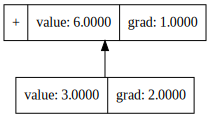

In [304]:
x = Value(3)
y = x + x

y.backward()

print(y.parents)

draw_graph(y)

adding 3 to 3.grad
adding 3 to 3.grad
[3, 3]


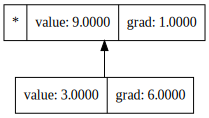

In [305]:
x = Value(3)
y = x * x

y.backward()

print(y.parents)

draw_graph(y)

adding 1 to -2.0.grad
adding 1 to -2.0.grad
adding 2 to -4.0.grad
adding 2 to 2.0.grad
[-2.0, -2.0]
[-4.0, 2.0]


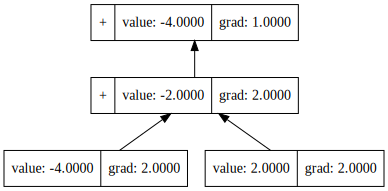

In [306]:
a = Value(-4.0)
b = Value(2.0)
c = a + b
o = c + c

o.backward()

print(o.parents)
print(list(o.parents)[0].parents)

draw_graph(o)

adding 1 to -2.0.grad
adding 1 to -1.0.grad
adding 1 to -4.0.grad
adding 1 to 2.0.grad
adding 1 to -2.0.grad
adding 1 to 1.grad
adding 2 to -4.0.grad
adding 2 to 2.0.grad


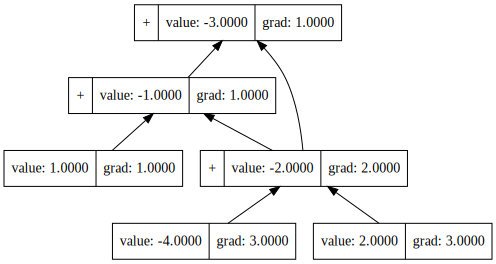

In [311]:
a = Value(-4.0)
b = Value(2.0)
c = a + b
c += c + 1

c.backward()

draw_graph(c)

## Graph Visualization

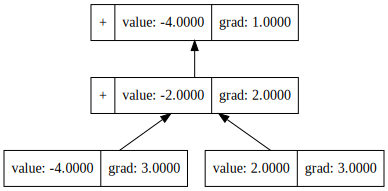

In [255]:
a = Value(-4.0)
b = Value(2.0)
c = a + b
# d = a * b + b**3
c += c + 1
# c += 1 + c + (-a)
# d += d * 2 + (b + a).relu()
# d += 3 * d + (b - a).relu()
# e = c - d
# f = e**2
# g = f / 2.0
# g += 10.0 / f

c.backward()

draw_graph(c)

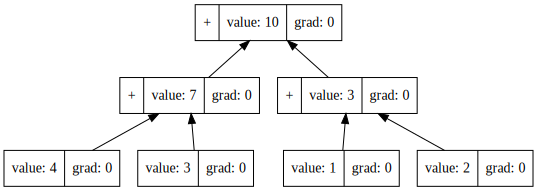

In [221]:
a = Value(1)
b = Value(2)
c = Value(3)
d = Value(4)
e = a + b
f = c + d
g = e + f

draw_graph(g)

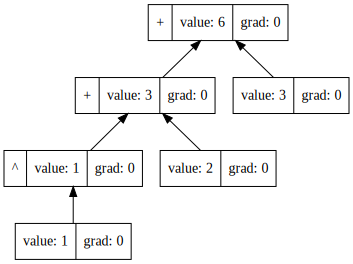

In [222]:
a = Value(1)
b = Value(2)
c = Value(3)
d = a**2 + b + c

draw_graph(d)